In [1]:
#Import libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist

import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

import gensim
from gensim.models import Word2Vec

np.random.seed(0)

%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/Filip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Filip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.


### Read and Load the Dataset

In [2]:
# Upload datasets
df = pd.read_csv('data/tweet_labeled.csv', encoding = 'unicode_escape')
df.head()

,text,label
0,@FamiLee_Farm @0xBingBong I first dissented in...,negative
1,A disaster.\n\nThe sooner aid agencies worldwi...,negative
2,With the very real threat of the government tr...,negative
3,Bitcoin mining's energy use has more than trip...,neutral
4,Tori Zero NFT Project Launched a Joint Coopera...,positive


### Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4766 entries, 0 to 4765
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4766 non-null   object
 1   label   4766 non-null   object
dtypes: object(2)
memory usage: 74.6+ KB


In [4]:
#Unique target variables
df['label'].unique()

array(['negative', 'neutral', 'positive'], dtype=object)

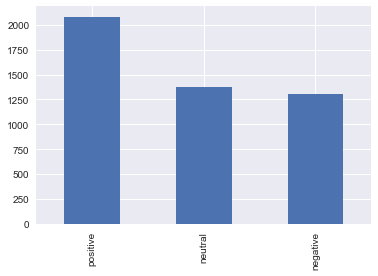

In [5]:
#Visualization of target variables
df['label'].value_counts().plot(kind='bar');

### Cleaning and Preprocessing Data

#### Break apart the data and the labels, and then inspect the class names

In [6]:
#Break apart the data and labels by dropping columns
data = df.drop(columns=['label'])
target = df.drop(columns=['text'])

In [7]:
#Check values for target encoding
c = target.label.astype('category')
label_names = dict(enumerate(c.cat.categories))
print (label_names)

{0: 'negative', 1: 'neutral', 2: 'positive'}


In [8]:
#Change type of column
#https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.Categorical.html
target['label'] = pd.Categorical(target['label'])

In [9]:
#Encode labels as per dictonary above
target['label'] = target['label'].cat.codes

In [10]:
class_names = list(label_names.keys())
class_names

[0, 1, 2]

In [11]:
#Address class weight imbalance by providing class weights with sklearn compute_class_weight function
class_weights = compute_class_weight('balanced', class_names, target['label'])
print(class_weights)

[1.21550625 1.15287857 0.76341502]


#### List of stopwords

In [12]:
# #### Getting a list of all of the english stopwords, and concatenating them with a list of all the punctuation.
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``', "'s"]

In [13]:
#Define function that returns tokenized lowercased tweet without stopwords
def process_tweet(tweet):
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed

In [14]:
#Check how removing stopwords works
process_tweet(data.text[0])

['familee_farm',
 '0xbingbong',
 'first',
 'dissented',
 '2018',
 'spot',
 'bitcoin',
 'etp',
 'denial',
 '4',
 'years',
 'later',
 'still',
 'approval',
 'sec',
 'remains',
 'mired',
 'unbounded',
 'dangerous',
 'territory',
 'merit',
 'regulation',
 'commission',
 'ill-equipped',
 'https',
 '//t.co/stmetrqpqn']

#### Check tweet length distribution and max value (including stopwords)

In [15]:
# Convert training data into tensors to feed into neural net
t = Tokenizer()

# Create tokenizer
t.fit_on_texts(data['text'])

In [49]:
# Find number of unique words in our tweets
vocab_size = len(t.word_index) + 1
vocab_size

15050

### Tweet vectorization

In [18]:
# This class allows to vectorize a text corpus, by turning each text into either a sequence of integers
sequences = t.texts_to_sequences(data['text'])

In [19]:
# Find longest tweet in sequences
def max_tweet():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

In [20]:
max_tweet_len = max_tweet()
max_tweet_len

45

In [21]:
#Truncate and pad input sequences to be all the same lenght vectors
padded_data = pad_sequences(sequences, maxlen=max_tweet_len)

In [22]:
padded_data

array([[ 6023,  3194,  6024, ...,     3,     4,  6028],
       [    0,     0,     0, ...,     3,     4,  6029],
       [    0,     0,     0, ...,     3,     4,  6030],
       ...,
       [    0,     0,     0, ...,     3,     4, 15043],
       [    0,     0,     0, ...,     3,     4, 15046],
       [    0,     0,     0, ...,     2,     1, 15049]], dtype=int32)

In [23]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_data, target, test_size = 0.2, random_state = 0)

In [24]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [25]:
# Size of train and test datasets
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

X_train size: (3812, 45)
y_train size: (3812, 3)
X_test size: (954, 45)
y_test size: (954, 3)


### Pre-trained word embedding

In [26]:
# # load the whole embedding into memory
# # https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# # 50 dimensional version (embedding dimension)
# embeddings_index = dict()
# f = open('glove/glove.twitter.27B.50d.txt')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()
# print('Loaded %s word vectors.' % len(embeddings_index))

In [27]:
import pickle

# with open('embeddings_index.pickle', 'wb') as handle:
#     pickle.dump(embeddings_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('embeddings_index.pickle', 'rb') as handle:
    embeddings_index = pickle.load(handle)

**Because we're using GloVE, need to create a word embedding/word context matrix**
- Create a matrix of weights for words in the training set

- One embedding for each word in the training set

- Get all unique words in our training set: Tokenizer index
- Find the corresponding weight vector in GloVe embedding


In [45]:
#Check word index dictionary
t.word_index['bitcoin']

1

In [46]:
# Define size of embedding matrix: number of unique words x embedding dim (100)
embedding_matrix = np.zeros((vocab_size, 50))

# fill in matrix
for word, i in t.word_index.items():  # dictionary
    embedding_vector = embeddings_index.get(word) # gets embedded vector of word from GloVe
    if embedding_vector is not None:
        # add to matrix
        embedding_matrix[i] = embedding_vector # each row of matrix

In [47]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.051568  ,  0.14289001, -0.92000002, ..., -0.037566  ,
        -0.030631  ,  1.44770002],
       [ 0.25319999, -0.014884  ,  0.59371001, ..., -0.28931999,
         0.45493001,  0.18659   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57010001,  0.80501997, -0.32980001, ..., -0.68456   ,
         0.097071  ,  0.46110001]])

In [48]:
# Input is vocab_size, output is 50
# Weights from embedding matrix, set trainable = False
tweet_num = max_tweet_len

#Create the embdedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=50, weights=[embedding_matrix],
                           input_length = tweet_num, trainable=False)

### Build Neural Net

In [50]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import BatchNormalization

In [51]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

#### Model 1: Simple LSTM Model with regularization, increase dimensionality

In [53]:
lstm_mod1 = Sequential()
lstm_mod1.add(embedding_layer)
lstm_mod1.add(LSTM(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod1.add(Dense(3, activation='softmax'))
lstm_mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 45, 50)            752500    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 1,067,639
Trainable params: 315,139
Non-trainable params: 752,500
_________________________________________________________________


In [54]:
history_1 = lstm_mod1.fit(X_train, y_train,
                    validation_split = 0.2, class_weight=class_weights,
                    epochs=100, batch_size=256)

Train on 3049 samples, validate on 763 samples
Epoch 1/100
3049/3049 [==============================] - 10s 3ms/step - loss: 1.0661 - acc: 0.4378 - val_loss: 1.0598 - val_acc: 0.4980
Epoch 2/100
3049/3049 [==============================] - 8s 3ms/step - loss: 1.0422 - acc: 0.4657 - val_loss: 1.0226 - val_acc: 0.4849
Epoch 3/100
3049/3049 [==============================] - 11s 4ms/step - loss: 1.0188 - acc: 0.4982 - val_loss: 0.9907 - val_acc: 0.5164
Epoch 4/100
3049/3049 [==============================] - 11s 4ms/step - loss: 0.9905 - acc: 0.5044 - val_loss: 0.9873 - val_acc: 0.5046
Epoch 5/100
3049/3049 [==============================] - 10s 3ms/step - loss: 0.9815 - acc: 0.5225 - val_loss: 0.9759 - val_acc: 0.5321
Epoch 6/100
3049/3049 [==============================] - 9s 3ms/step - loss: 0.9777 - acc: 0.5290 - val_loss: 0.9648 - val_acc: 0.5360
Epoch 7/100
3049/3049 [==============================] - 9s 3ms/step - loss: 0.9706 - acc: 0.5257 - val_loss: 0.9752 - val_acc: 0.5177
Epoc

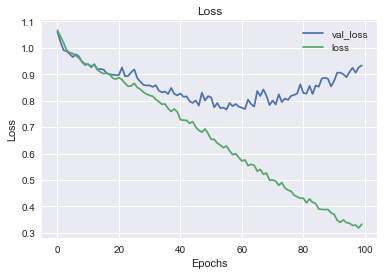

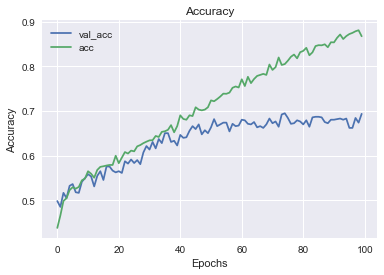

In [55]:
visualize_training_results(history_1)

In [56]:
# Find train and test accuracy
loss, accuracy = lstm_mod1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#0.90/0.66

Training Accuracy: 0.9200
Testing Accuracy:  0.7138


### Model 2: LSTM with regularization, reduce dimensionality

In [63]:
lstm_mod2 = Sequential()
lstm_mod2.add(embedding_layer)
lstm_mod2.add(LSTM(100, 
               dropout = 0.3, 
               recurrent_dropout = 0.5))
lstm_mod2.add(Dense(3, activation='softmax'))
lstm_mod2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 45, 50)            752500    
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 303       
Total params: 813,203
Trainable params: 60,703
Non-trainable params: 752,500
_________________________________________________________________


In [64]:
# Import EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=15), 
                  ModelCheckpoint(filepath='best_model_lstm.h5', monitor='val_loss', save_best_only=True)]

In [65]:
history_2 = lstm_mod2.fit(X_train, y_train,
                    validation_split = 0.2, 
                    class_weight=class_weights,
                    callbacks=early_stopping,
                    epochs=200, batch_size=500)

Train on 3049 samples, validate on 763 samples
Epoch 1/200
3049/3049 [==============================] - 4s 1ms/step - loss: 1.0976 - acc: 0.3883 - val_loss: 1.0801 - val_acc: 0.4181
Epoch 2/200
3049/3049 [==============================] - 3s 951us/step - loss: 1.0664 - acc: 0.4418 - val_loss: 1.0596 - val_acc: 0.4325
Epoch 3/200
3049/3049 [==============================] - 3s 955us/step - loss: 1.0600 - acc: 0.4428 - val_loss: 1.0530 - val_acc: 0.4312
Epoch 4/200
3049/3049 [==============================] - 2s 819us/step - loss: 1.0515 - acc: 0.4506 - val_loss: 1.0464 - val_acc: 0.4351
Epoch 5/200
3049/3049 [==============================] - 3s 846us/step - loss: 1.0472 - acc: 0.4480 - val_loss: 1.0328 - val_acc: 0.4522
Epoch 6/200
3049/3049 [==============================] - 2s 802us/step - loss: 1.0336 - acc: 0.4631 - val_loss: 1.0233 - val_acc: 0.4548
Epoch 7/200
3049/3049 [==============================] - 2s 808us/step - loss: 1.0297 - acc: 0.4654 - val_loss: 1.0160 - val_acc: 0.4

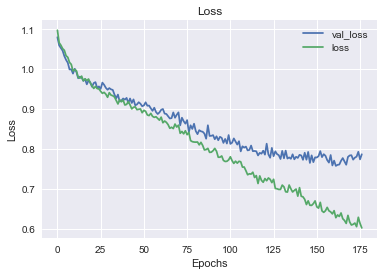

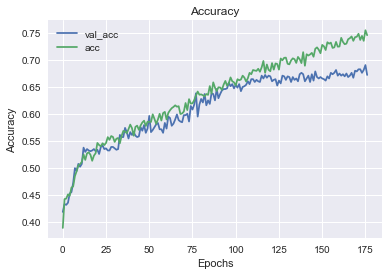

In [66]:
visualize_training_results(history_2)

In [67]:
# Find train and test accuracy
loss, accuracy = lstm_mod2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7977
Testing Accuracy:  0.7055


### Model 3: LSTM Layer Stacking

In [68]:
lstm_mod3 = Sequential()
lstm_mod3.add(embedding_layer)
# lstm_mod3.add(Dropout(0.3))
lstm_mod3.add(LSTM(80, 
               dropout = 0.3, 
               recurrent_dropout = 0.5,
               return_sequences = True))
lstm_mod3.add(LSTM(20, 
               dropout = 0.3, 
               recurrent_dropout = 0.5))

lstm_mod3.add(Dense(3, activation='softmax'))
lstm_mod3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 45, 50)            752500    
_________________________________________________________________
lstm_6 (LSTM)                (None, 45, 80)            41920     
_________________________________________________________________
lstm_7 (LSTM)                (None, 20)                8080      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 63        
Total params: 802,563
Trainable params: 50,063
Non-trainable params: 752,500
_________________________________________________________________


In [69]:
# Import EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=15), 
                  ModelCheckpoint(filepath='best_model_lstm.h5', monitor='val_loss', save_best_only=True)]

In [70]:
history_3 = lstm_mod3.fit(X_train, y_train,
                    validation_split = 0.2,
                    callbacks=early_stopping, 
                    class_weight=class_weights,
                    epochs=200, batch_size=500)

Train on 3049 samples, validate on 763 samples
Epoch 1/200
3049/3049 [==============================] - 6s 2ms/step - loss: 1.0863 - acc: 0.4064 - val_loss: 1.0740 - val_acc: 0.4181
Epoch 2/200
3049/3049 [==============================] - 4s 1ms/step - loss: 1.0684 - acc: 0.4382 - val_loss: 1.0630 - val_acc: 0.4194
Epoch 3/200
3049/3049 [==============================] - 3s 1ms/step - loss: 1.0618 - acc: 0.4497 - val_loss: 1.0513 - val_acc: 0.4456
Epoch 4/200
3049/3049 [==============================] - 4s 1ms/step - loss: 1.0536 - acc: 0.4592 - val_loss: 1.0411 - val_acc: 0.4404
Epoch 5/200
3049/3049 [==============================] - 4s 1ms/step - loss: 1.0460 - acc: 0.4710 - val_loss: 1.0312 - val_acc: 0.4574
Epoch 6/200
3049/3049 [==============================] - 4s 1ms/step - loss: 1.0368 - acc: 0.4841 - val_loss: 1.0150 - val_acc: 0.5020
Epoch 7/200
3049/3049 [==============================] - 4s 1ms/step - loss: 1.0161 - acc: 0.5011 - val_loss: 1.0052 - val_acc: 0.5007
Epoch 8/

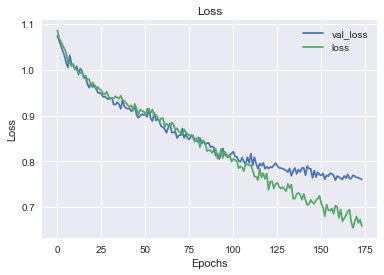

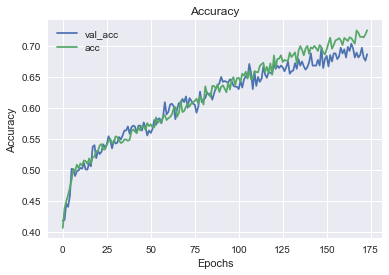

In [71]:
visualize_training_results(history_3)

In [72]:
# Find train and test accuracy
loss, accuracy = lstm_mod3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7875
Testing Accuracy:  0.7065


In [73]:
y_pred = lstm_mod3.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [79]:
Y_test = np.argmax(y_test, axis=1)

#### Plot confusion matrix

In [76]:
class_names = np.array(['Negative', 'Positive', 'Neutral'])

In [77]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    plt.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[176  28  69]
 [ 24 156  71]
 [ 40  48 342]]
Normalized confusion matrix
[[0.64 0.1  0.25]
 [0.1  0.62 0.28]
 [0.09 0.11 0.8 ]]


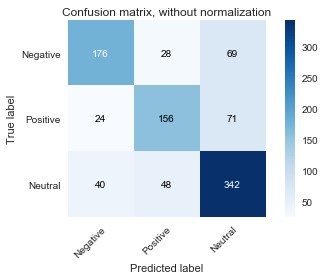

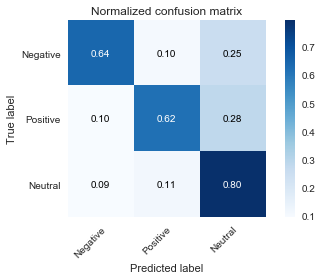

In [78]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 4: GRU Layer Stacking

In [86]:
# GRU Model 2: reduce number of epochs
model_4 = Sequential()
model_4.add(embedding_layer)
model_4.add(GRU(64, 
               dropout = 0.3, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
model_4.add(GRU(32,
                dropout = 0.3,
                recurrent_dropout = 0.5))
model_4.add(Dense(3, activation='softmax'))
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 45, 50)            752500    
_________________________________________________________________
gru_3 (GRU)                  (None, 45, 64)            22080     
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                9312      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 783,991
Trainable params: 31,491
Non-trainable params: 752,500
_________________________________________________________________


In [87]:
# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=15), 
                  ModelCheckpoint(filepath='best_model_gru.h5', monitor='val_loss', save_best_only=True)]

In [88]:
history_4 = model_4.fit(X_train, y_train,
                    validation_split = 0.2,
                    callbacks=early_stopping, 
                    class_weight=class_weights,
                    epochs=300, batch_size=600)

Train on 3049 samples, validate on 763 samples
Epoch 1/300
3049/3049 [==============================] - 6s 2ms/step - loss: 1.1116 - acc: 0.3837 - val_loss: 1.0821 - val_acc: 0.4181
Epoch 2/300
3049/3049 [==============================] - 3s 825us/step - loss: 1.0875 - acc: 0.4175 - val_loss: 1.0685 - val_acc: 0.4168
Epoch 3/300
3049/3049 [==============================] - 2s 712us/step - loss: 1.0786 - acc: 0.4175 - val_loss: 1.0638 - val_acc: 0.4286
Epoch 4/300
3049/3049 [==============================] - 3s 977us/step - loss: 1.0742 - acc: 0.4313 - val_loss: 1.0627 - val_acc: 0.4273
Epoch 5/300
3049/3049 [==============================] - 2s 706us/step - loss: 1.0691 - acc: 0.4356 - val_loss: 1.0574 - val_acc: 0.4312
Epoch 6/300
3049/3049 [==============================] - 2s 753us/step - loss: 1.0618 - acc: 0.4375 - val_loss: 1.0534 - val_acc: 0.4351
Epoch 7/300
3049/3049 [==============================] - 2s 695us/step - loss: 1.0651 - acc: 0.4415 - val_loss: 1.0519 - val_acc: 0.4

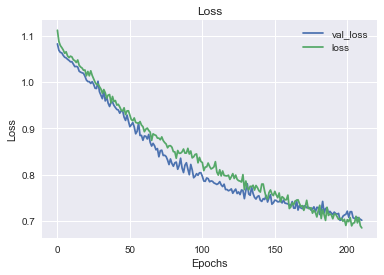

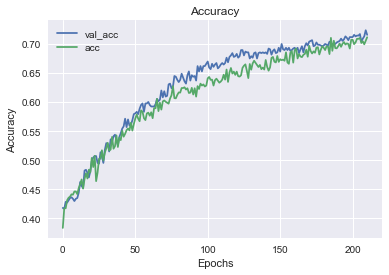

In [89]:
visualize_training_results(history_4)

In [90]:
# Find train and test accuracy
loss, accuracy = model_4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7891
Testing Accuracy:  0.7096


In [ ]:
make preditions with best_model_gru